In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

## Read data and build a TimeSeries

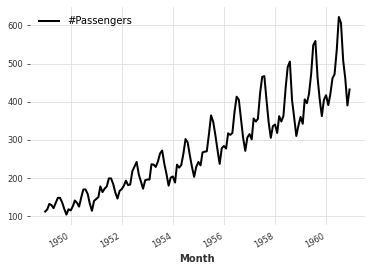

In [2]:
series = AirPassengersDataset().load()
series.plot()

## Some TimeSeries Operations

### splitting

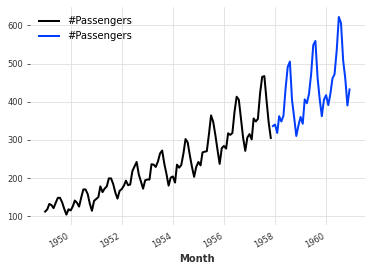

In [3]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

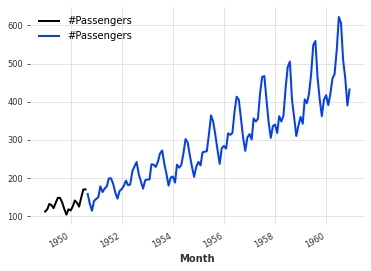

In [4]:
series1, series2 = series.split_before(pd.Timestamp('1950-09'))
series1.plot()
series2.plot()

### slicing

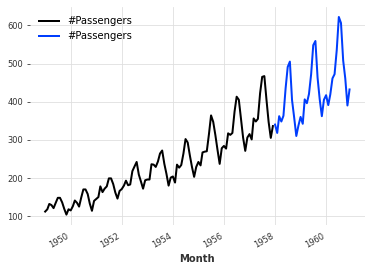

In [5]:
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

### arithmetic operations

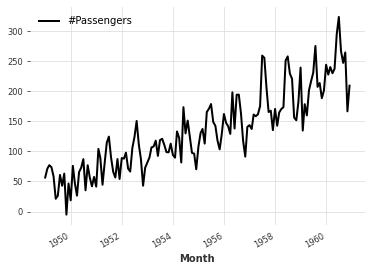

In [26]:
series_noise = TimeSeries.from_times_and_values(series.time_index, np.random.randn(len(series)))
(series / 2 + 20 * series_noise - 10).plot()

### stacking

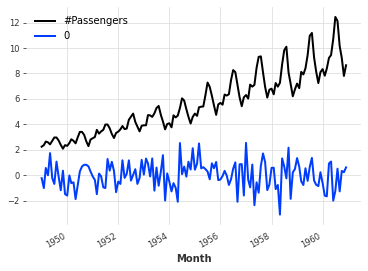

In [25]:
s = (series / 50).stack(series_noise)
s.plot()

### mapping

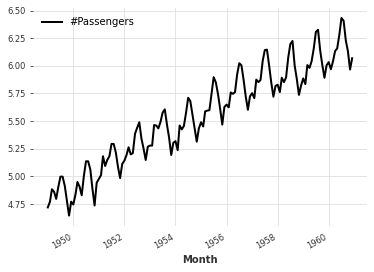

In [8]:
series.map(np.log).plot()

### mapping on both timestamps and values

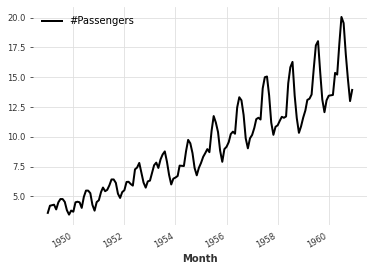

In [9]:
series.map(lambda ts, x: x / ts.days_in_month).plot()


### Adding some datetime attribute as an extra dimension (yielding a multivariate series)

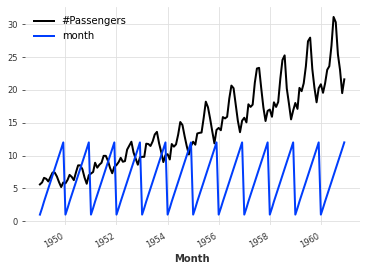

In [10]:
(series / 20).add_datetime_attribute("month").plot()

### Adding some binary holidays component

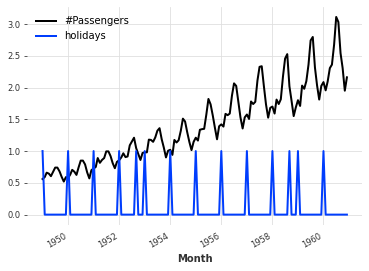

In [13]:
(series / 200).add_holidays('US').plot()

### differencing

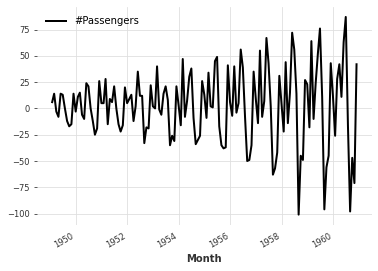

In [18]:
series.diff().plot()

### Filling missing values (using a ``utils`` function).

Missing values are represented by np.nan.

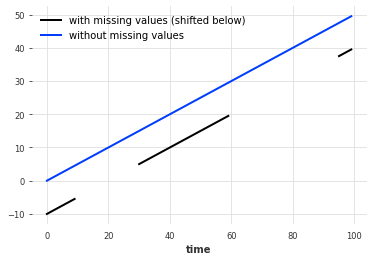

In [21]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## Creating a training and validation series

For what follows, we will split our TimeSeries into a training and a validation series. Note: in general, it is also a good practice to keep a test series aside and never touch it until the end of the process. Here, we just build a training and a validation series for simplicity. 

The training series will be a TimeSeries containing values until January 1958 (excluded), and the validation series a TimeSeries containing the rest:

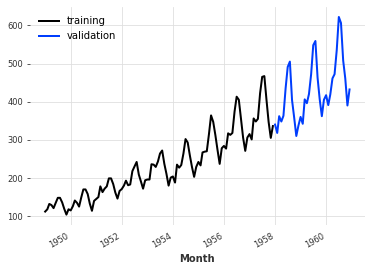

In [27]:
train, val = series.split_before(pd.Timestamp('19580101'))
train.plot(label='training')
val.plot(label='validation')

## Training forecasting models and making predictions

### Playing with toy models

There is a collection of “naive” baseline models in Darts, which can be very useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always “repeats” the value that occured K time steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series: